# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data
TODO:
- How am I calculation loss (sometimes test loss lower than train)
- SVM


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
import torch
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import data

In [2]:
### Load the data
seed = 90 # 12: test better as train
data_path = 'data/output/data_complete_grouped_2022-06-22.csv'
df = pd.read_csv(data_path)

# Scale Data

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
M = scaler.fit_transform(df.drop(columns=['dataset', 'Thermal feeling (global)']))
#M = df.drop(columns='dataset').to_numpy()
# y = M[:,-1]
y = df['Thermal feeling (global)'].to_numpy() + 1
#X = M[:,:-1]
X = M

# Train

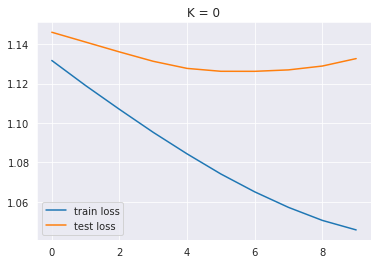

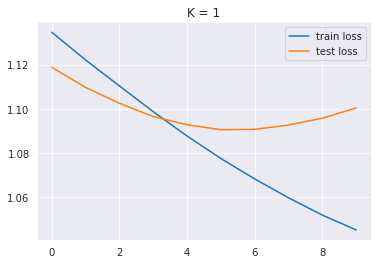

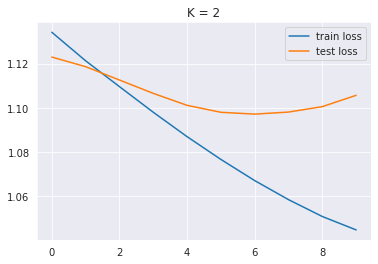

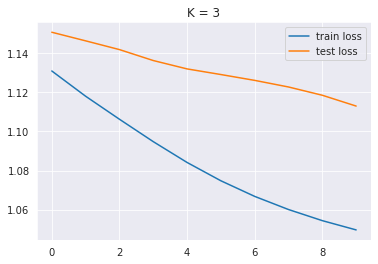

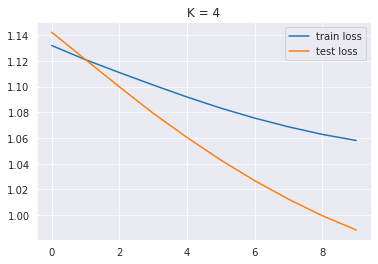

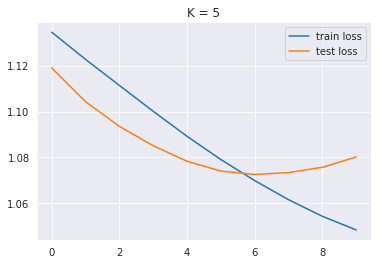

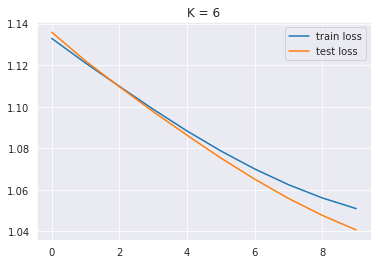

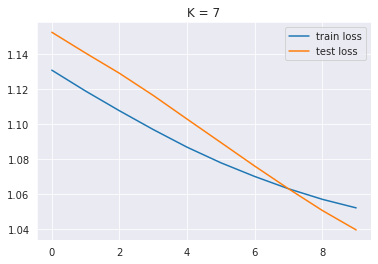

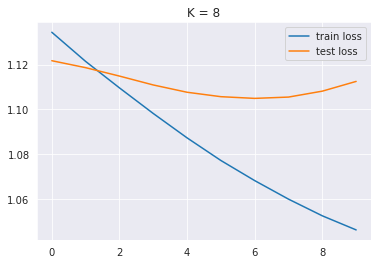

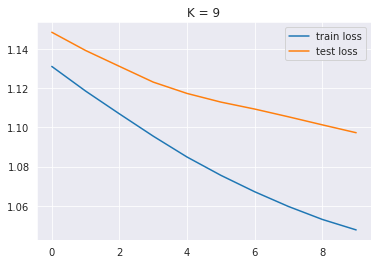

In [5]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

import numpy as np
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

test_values = []
predicted_values = []
datasets = []
# Test split using K-Folds cross-validator
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    # Slicing data according to kf split
    dtype = torch.float32
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Hyper-parameters for one train test session
    torch.manual_seed(seed)
    method = NNClassifier(input_size=x_train.shape[1])

    x_train = torch.tensor(x_train,dtype=dtype)
    x_test = torch.tensor(x_test, dtype=dtype)
    if method.type == 'predictor':
        y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
        y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)
    elif method.type == 'classifier':
        y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)
        y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)

    criterion = method.criterion
    params_to_be_optimized = method.get_parameters()
    optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
    #scheduler = ExponentialLR(optimizer, gamma=0.999)
    train_losses = []  # for plot
    test_losses = []  # for plot

    epochs = 10
    for epoch in range(epochs):
      iteration_time = time.time()
      optimizer.zero_grad()

      # forward pass
      y_train_predicted = method.predict(x_train)
      loss = criterion(y_train_predicted, y_train)

      # backward pass
      loss.backward()
      optimizer.step()
      #scheduler.step()

      with torch.no_grad():
        y_train_predicted = method.predict(x_train)
        train_loss = criterion(y_train_predicted, y_train)
        train_losses.append(train_loss)

        y_test_predicted = method.predict(x_test)
        test_loss = criterion(y_test_predicted, y_test)
        test_losses.append(test_loss)

    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.title(f'K = {idx}')
    plt.show()

        # Lists for Error Analysis df
    if method.type == "predictor":
        test_values += y_test.detach().numpy().reshape(-1).tolist()
        predicted_values += method.predict(x_test).detach().numpy().reshape(-1).tolist()
        datasets += df['dataset'][test_index].tolist()
    elif method.type == "classifier":
        test_values += y_test.detach().numpy().tolist()
        predicted_values += torch.argmax(method.predict(x_test), dim=1).detach().numpy().tolist()
        datasets += df['dataset'][test_index].tolist()


# Test Analysis

In [6]:
analysis_df = pd.DataFrame({'dataset':datasets, 'y': test_values, 'pred': predicted_values})

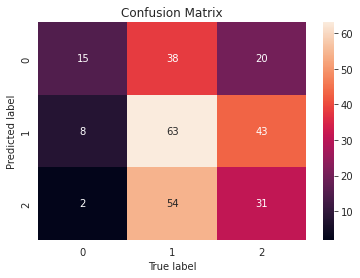

In [7]:

cm = confusion_matrix(analysis_df['y'], analysis_df['pred'])
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

## Predictor Analysis

In [ ]:
analysis_df['error'] = analysis_df['y']-analysis_df['pred']
analysis_df['error_abs'] = np.abs(analysis_df['error'])
diff = analysis_df['y'].max()-analysis_df['y'].min()
analysis_df['accuracy'] = 1 - analysis_df['error_abs'] / diff

In [23]:
analysis_df['accuracy'].describe()

count    274.000000
mean       0.684307
std        0.263413
min        0.000000
25%        0.500000
50%        0.500000
75%        1.000000
max        1.000000
Name: accuracy, dtype: float64

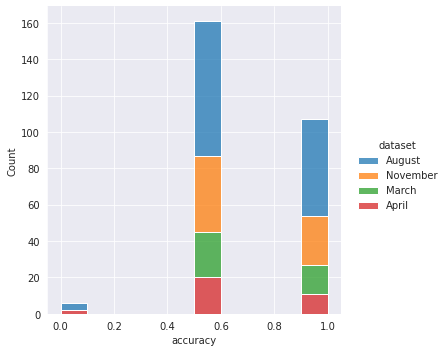

In [24]:
sns.displot(data=analysis_df, x="accuracy", hue="dataset", multiple="stack")
plt.show()

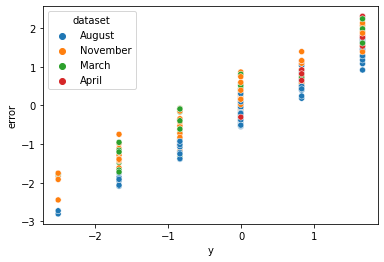

In [73]:
sns.scatterplot(data=analysis_df, x="y", y="error", hue="dataset")
plt.show()

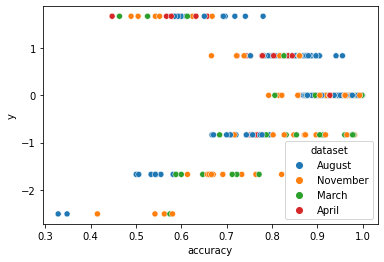

In [74]:
sns.scatterplot(data=analysis_df, x="accuracy", y="y", hue="dataset")
plt.show()

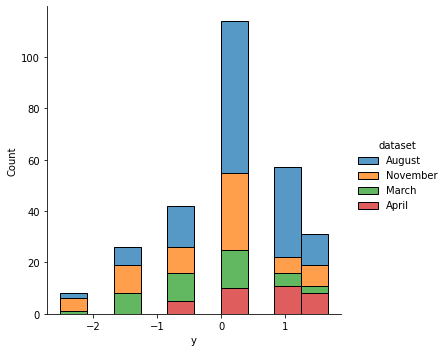

In [75]:
sns.displot(data=analysis_df, x="y", hue="dataset", multiple="stack")
plt.show()

In [76]:
df.columns

Index(['dataset', 'Outside Temperature', 'Avg. Temperature', 'RH', 'va', 'Tg',
       'Gender', 'Age', 'Height', 'Weight', 'Duration', 'Icl',
       'Thermal feeling (global)'],
      dtype='object')

In [77]:
method.get_parameters()

[Parameter containing:
 tensor([[-0.0369,  0.3965,  0.1280, -0.1134,  0.0526, -0.0828, -0.1120,  0.1507,
           0.0453, -0.0434,  0.0533]], requires_grad=True),
 Parameter containing:
 tensor([0.0199], requires_grad=True)]

In [79]:
df['Thermal feeling (global)'].value_counts()

 0    114
 1     57
-1     42
 2     31
-2     26
-3      8
Name: Thermal feeling (global), dtype: int64

TODO:
- hybrido
- implenetar clasifier
- agrupar "Y" en neutral o no neutral
- reducir numeros de inputs (por logica, o por resultados de regresion linear)
- (largo plazo)temperatura optimal de adentro basado en temperatura afuera
- clustering